In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm


%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
fake = glob("/content/drive/My Drive/My Stuff/Subjects/Sem V/Signal And Image Processing/faces/fake/*")
real = glob("/content/drive/My Drive/My Stuff/Subjects/Sem V/Signal And Image Processing/faces/real/*")

In [ ]:
fake_ = [x.split("/")[-1] for x in fake]
real_ = [x.split("/")[-1] for x in real]

fake_ = ["fake_" + x for x in fake_]

In [ ]:
start = time.time()

pairs_distinct = list(product(real_,fake_))

pairs_real = list(product(real_,real_))

pairs_fake = list(product(fake_,fake_))

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:00.289923


In [ ]:
len(pairs_distinct) + len(pairs_fake) + len(pairs_real)

3127921

In [ ]:
pairs = pairs_distinct + pairs_real + pairs_fake
pairs = sample(pairs, len(pairs))
pairs = list(set(pairs))

In [ ]:
ord('f'), ord('r')

(102, 114)

In [ ]:
start = time.time()

label_dict = {}
for idx, pair in enumerate(pairs):
    l1, l2 = pair[0].split("_")[0][0], pair[1].split("_")[0][0]
    
    l_sum = ord(l1) + ord(l2)
    
    if l_sum == 204:
        label = 1 #impostor pair
    elif l_sum == 216:
        label = 1
    elif l_sum == 228:
        label = 0 # real pair
    
    label_dict[idx] = label

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:03.907065


In [ ]:
class DFDataset(Dataset):
    
    def __init__(self, root_dir, real_dir, fake_dir, pairs, lab_dict, transform=None):
        self.root_dir = root_dir
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.pairs = pairs
        self.lab_dict = lab_dict
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        
        if pair[0].split("_")[0] == "real":
            img1 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[0]}')
            
        elif pair[0].split("_")[0] == "fake":
            path_ = pair[0].replace('fake_', '')
            img1 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            
        if pair[1].split("_")[0] == "real":
            img2 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[1]}')
            
        elif pair[1].split("_")[0] == "fake":
            path_ = pair[1].replace('fake_', '')
            img2 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        
        label = self.lab_dict[idx]
        
        return img1, img2, label
        

In [ ]:
BATCH_SIZE=8
NUMBER_EPOCHS=100
IMG_SIZE=100

In [ ]:
len(pairs)

3127921

In [ ]:
a, b, c = np.array_split(pairs, 3)

In [ ]:
len(a), len(b), len(c)

(1042641, 1042640, 1042640)

In [ ]:
trainset = DFDataset('/content/drive/My Drive/My Stuff/Subjects/Sem V/Signal And Image Processing/faces', 'real', 'fake', sample(list(a), 1000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


valset = DFDataset('/content/drive/My Drive/My Stuff/Subjects/Sem V/Signal And Image Processing/faces', 'real', 'fake', sample(list(b), 1000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

valloader = DataLoader(valset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

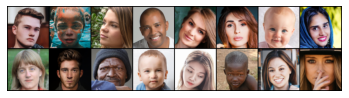

[1 1 1 0 1 0 1 0]


In [ ]:
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #self.cnn1 = models.resnet50(pretrained=True)#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(2*32*100*100, 500)
        #self.fc1 = nn.Linear(2*1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)


    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

Epoch： 0  start.
Accuracy of the network on the 1000 : 54 %


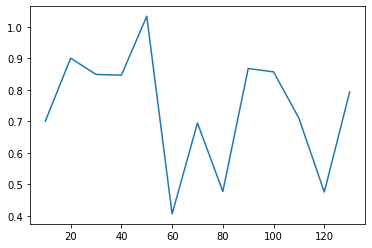

Epoch： 1  start.
Accuracy of the network on the 1000 : 57 %


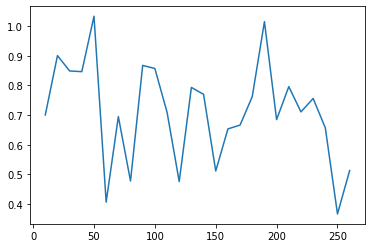

Epoch： 2  start.
Accuracy of the network on the 1000 : 50 %


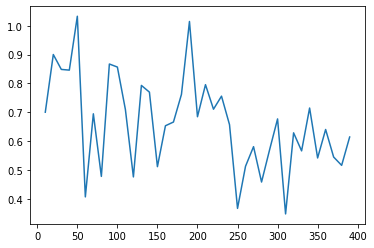

Epoch： 3  start.
Accuracy of the network on the 1000 : 52 %


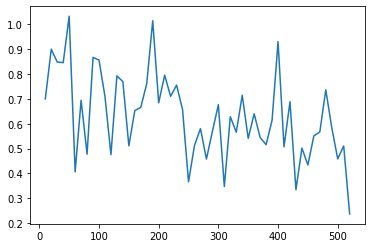

Epoch： 4  start.
Accuracy of the network on the 1000 : 52 %


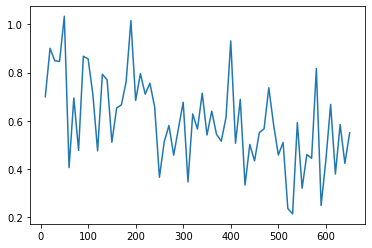

Epoch： 5  start.
Accuracy of the network on the 1000 : 58 %


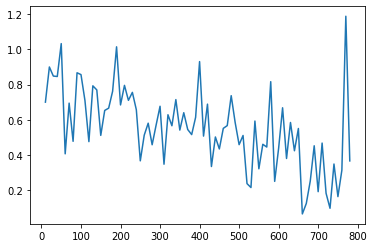

Epoch： 6  start.
Accuracy of the network on the 1000 : 55 %


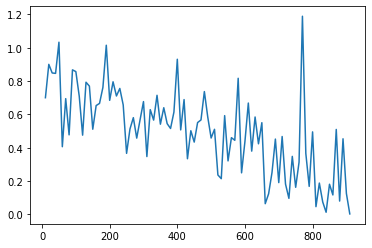

Epoch： 7  start.
Accuracy of the network on the 1000 : 56 %


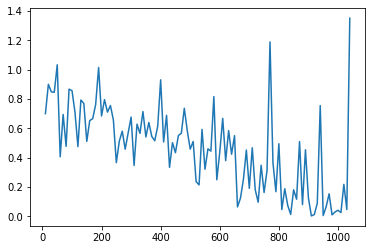

Epoch： 8  start.
Accuracy of the network on the 1000 : 53 %


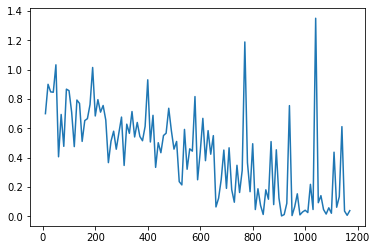

Epoch： 9  start.
Accuracy of the network on the 1000 : 54 %


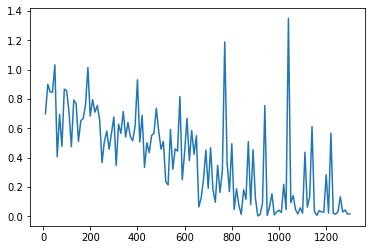

Epoch： 10  start.
Accuracy of the network on the 1000 : 51 %


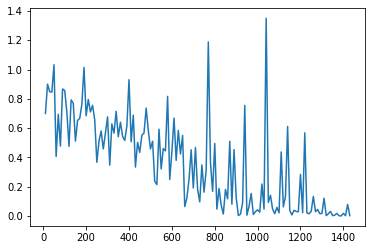

Epoch： 11  start.
Accuracy of the network on the 1000 : 53 %


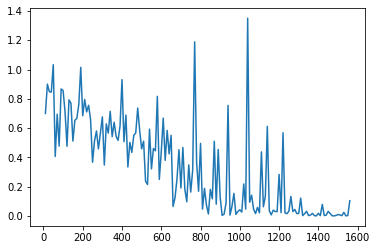

Epoch： 12  start.
Accuracy of the network on the 1000 : 53 %


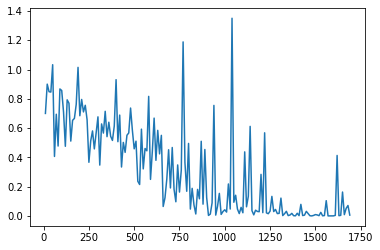

Epoch： 13  start.
Accuracy of the network on the 1000 : 51 %


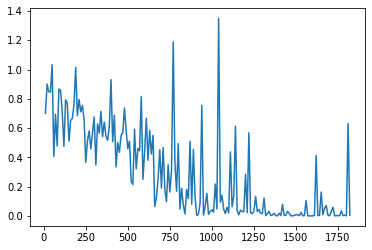

Epoch： 14  start.
Accuracy of the network on the 1000 : 54 %


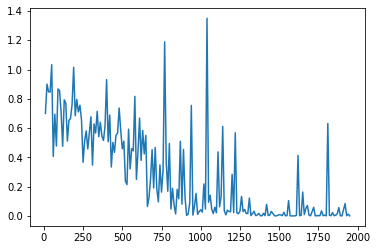

Epoch： 15  start.
Accuracy of the network on the 1000 : 54 %


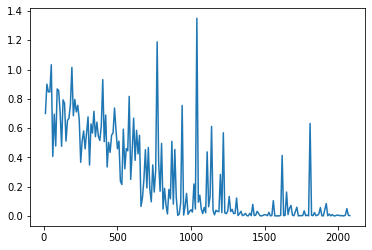

Epoch： 16  start.
Accuracy of the network on the 1000 : 54 %


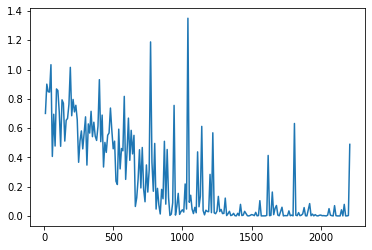

Epoch： 17  start.
Accuracy of the network on the 1000 : 53 %


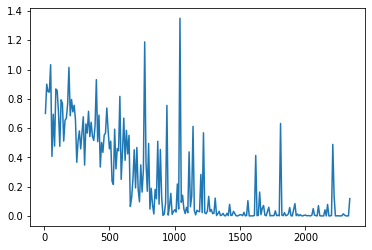

Epoch： 18  start.
Accuracy of the network on the 1000 : 53 %


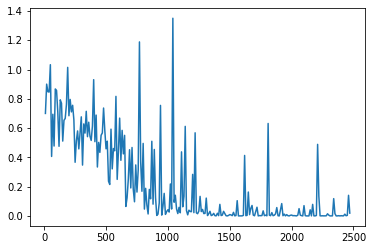

Epoch： 19  start.
Accuracy of the network on the 1000 : 56 %


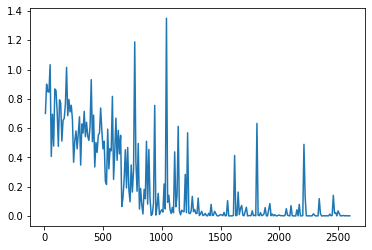

Epoch： 20  start.
Accuracy of the network on the 1000 : 55 %


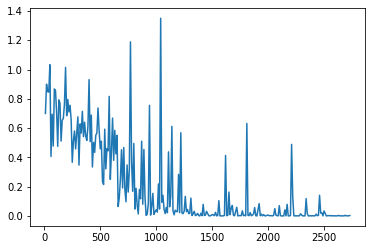

Epoch： 21  start.
Accuracy of the network on the 1000 : 52 %


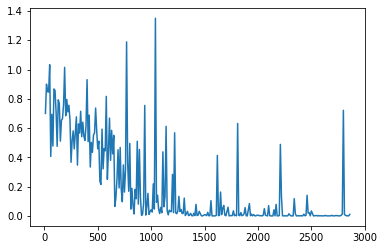

Epoch： 22  start.
Accuracy of the network on the 1000 : 54 %


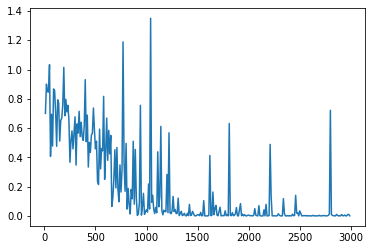

Epoch： 23  start.
Accuracy of the network on the 1000 : 54 %


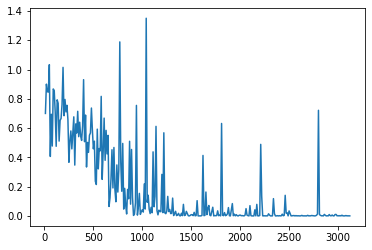

Epoch： 24  start.
Accuracy of the network on the 1000 : 52 %


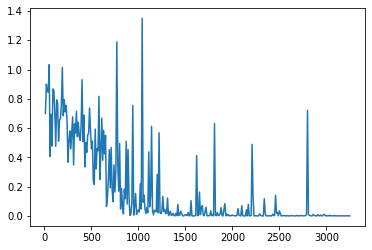

Epoch： 25  start.
Accuracy of the network on the 1000 : 57 %


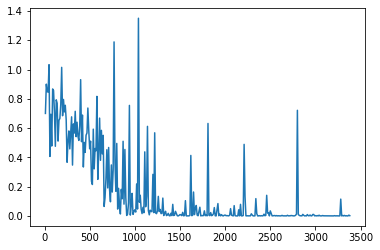

Epoch： 26  start.
Accuracy of the network on the 1000 : 55 %


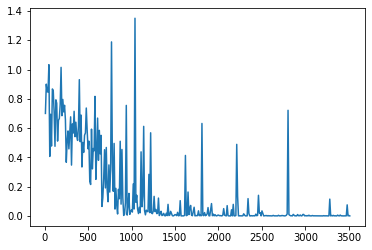

Epoch： 27  start.
Accuracy of the network on the 1000 : 55 %


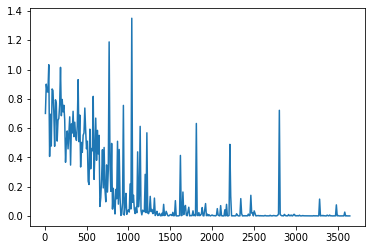

Epoch： 28  start.
Accuracy of the network on the 1000 : 55 %


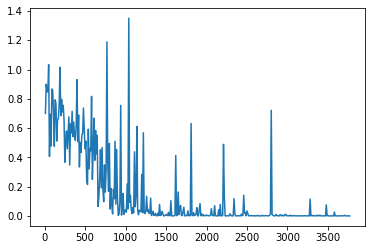

Epoch： 29  start.
Accuracy of the network on the 1000 : 54 %


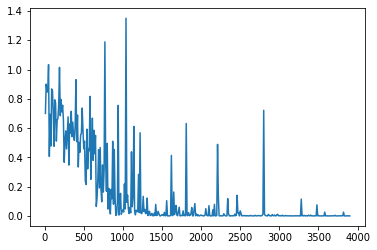

Epoch： 30  start.
Accuracy of the network on the 1000 : 53 %


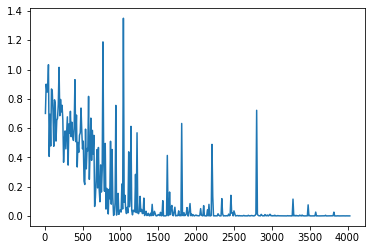

Epoch： 31  start.
Accuracy of the network on the 1000 : 53 %


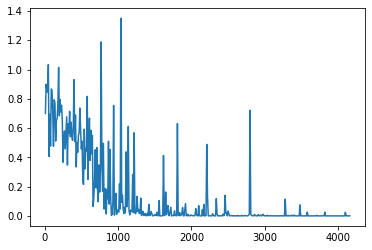

Epoch： 32  start.
Accuracy of the network on the 1000 : 54 %


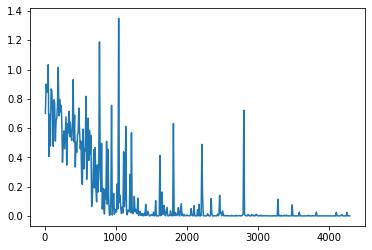

Epoch： 33  start.
Accuracy of the network on the 1000 : 51 %


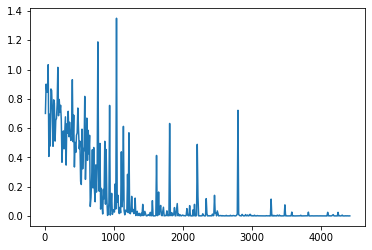

Epoch： 34  start.
Accuracy of the network on the 1000 : 54 %


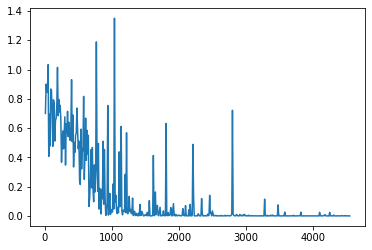

Epoch： 35  start.
Accuracy of the network on the 1000 : 54 %


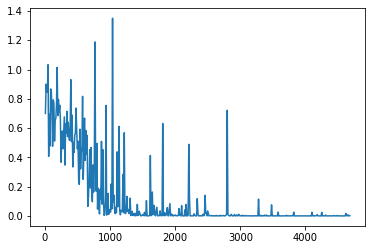

Epoch： 36  start.
Accuracy of the network on the 1000 : 53 %


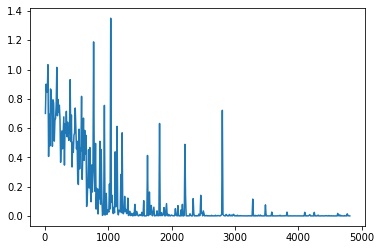

Epoch： 37  start.
Accuracy of the network on the 1000 : 54 %


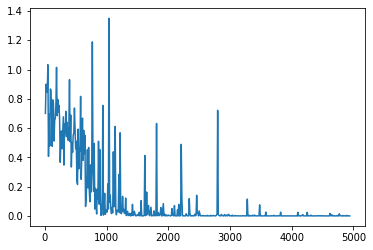

Epoch： 38  start.
Accuracy of the network on the 1000 : 55 %


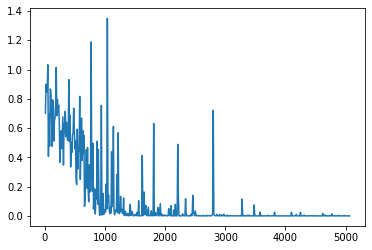

Epoch： 39  start.
Accuracy of the network on the 1000 : 54 %


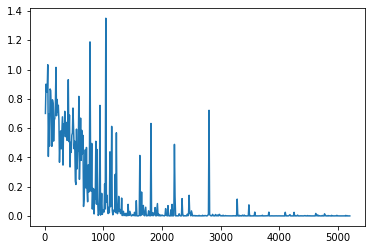

Epoch： 40  start.
Accuracy of the network on the 1000 : 56 %


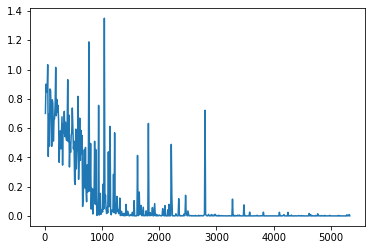

Epoch： 41  start.
Accuracy of the network on the 1000 : 54 %


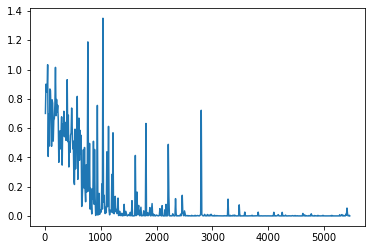

Epoch： 42  start.
Accuracy of the network on the 1000 : 56 %


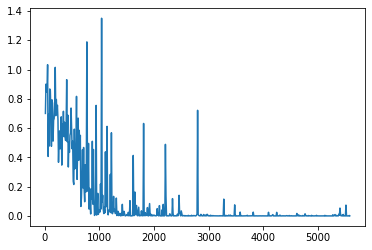

Epoch： 43  start.
Accuracy of the network on the 1000 : 53 %


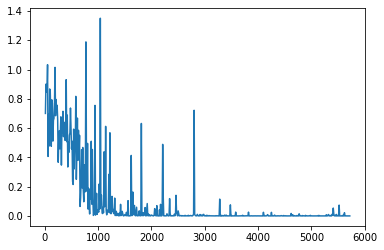

Epoch： 44  start.
Accuracy of the network on the 1000 : 55 %


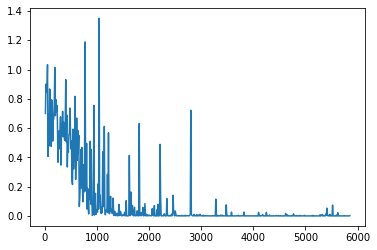

Epoch： 45  start.
Accuracy of the network on the 1000 : 54 %


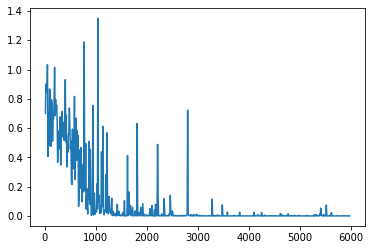

Epoch： 46  start.
Accuracy of the network on the 1000 : 55 %


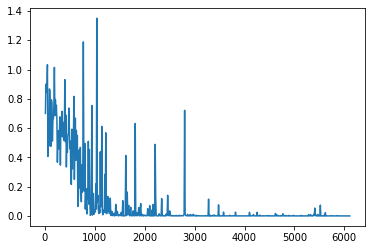

Epoch： 47  start.
Accuracy of the network on the 1000 : 55 %


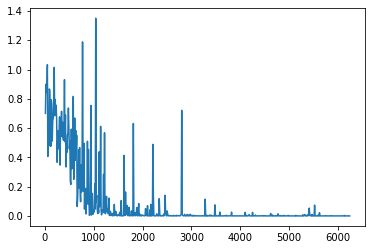

Epoch： 48  start.
Accuracy of the network on the 1000 : 53 %


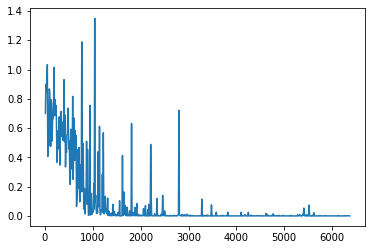

Epoch： 49  start.
Accuracy of the network on the 1000 : 54 %


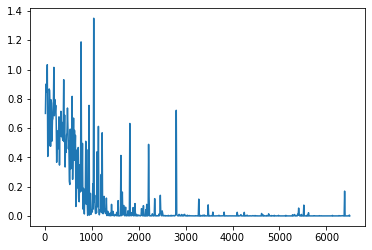

Epoch： 50  start.
Accuracy of the network on the 1000 : 54 %


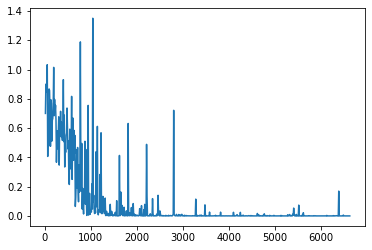

Epoch： 51  start.
Accuracy of the network on the 1000 : 53 %


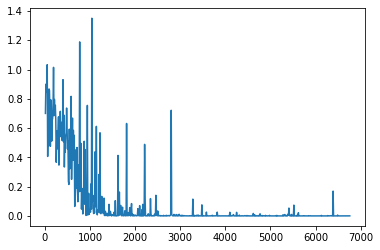

Epoch： 52  start.
Accuracy of the network on the 1000 : 56 %


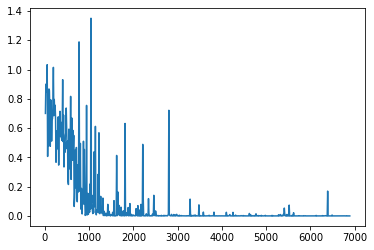

Epoch： 53  start.
Accuracy of the network on the 1000 : 55 %


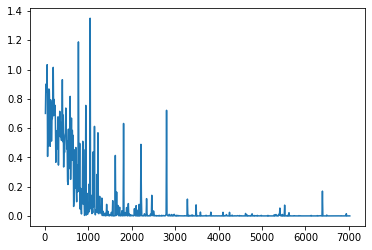

Epoch： 54  start.
Accuracy of the network on the 1000 : 54 %


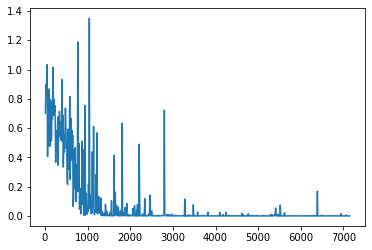

Epoch： 55  start.
Accuracy of the network on the 1000 : 54 %


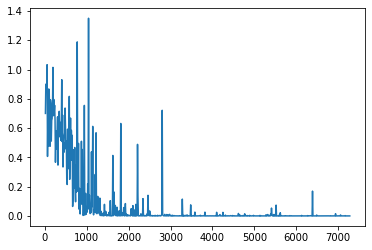

Epoch： 56  start.
Accuracy of the network on the 1000 : 54 %


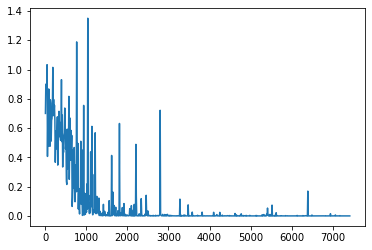

Epoch： 57  start.
Accuracy of the network on the 1000 : 54 %


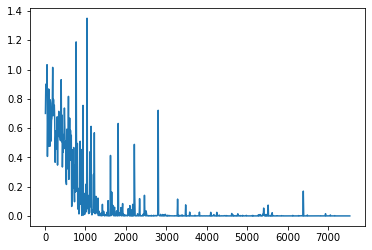

Epoch： 58  start.
Accuracy of the network on the 1000 : 54 %


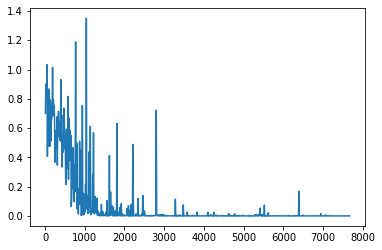

Epoch： 59  start.
Accuracy of the network on the 1000 : 56 %


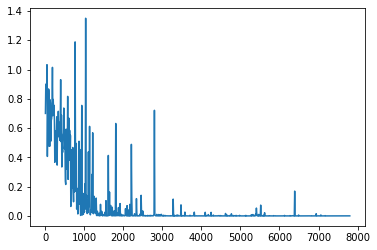

Epoch： 60  start.
Accuracy of the network on the 1000 : 55 %


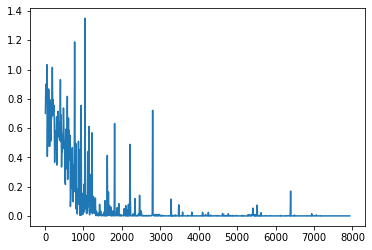

Epoch： 61  start.
Accuracy of the network on the 1000 : 55 %


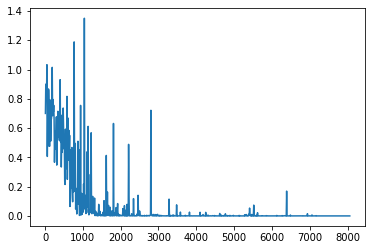

Epoch： 62  start.
Accuracy of the network on the 1000 : 53 %


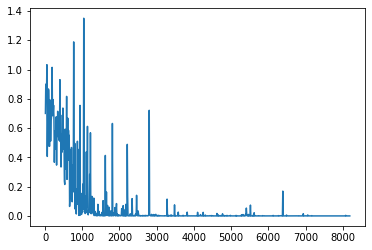

Epoch： 63  start.
Accuracy of the network on the 1000 : 54 %


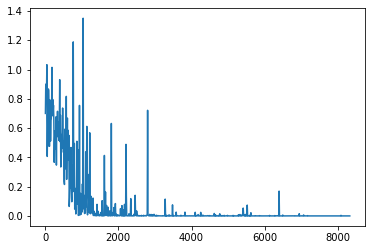

Epoch： 64  start.
Accuracy of the network on the 1000 : 53 %


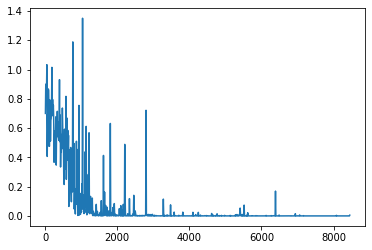

Epoch： 65  start.
Accuracy of the network on the 1000 : 54 %


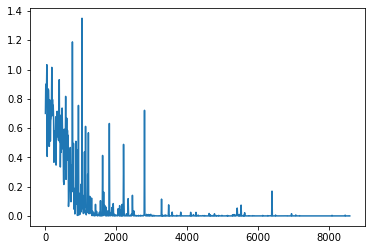

Epoch： 66  start.
Accuracy of the network on the 1000 : 54 %


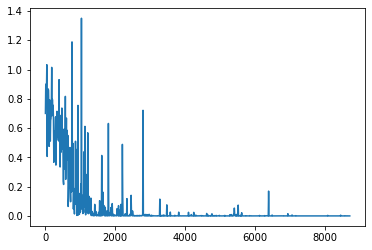

Epoch： 67  start.
Accuracy of the network on the 1000 : 56 %


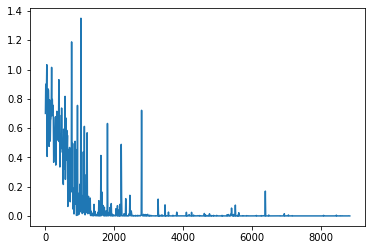

Epoch： 68  start.
Accuracy of the network on the 1000 : 55 %


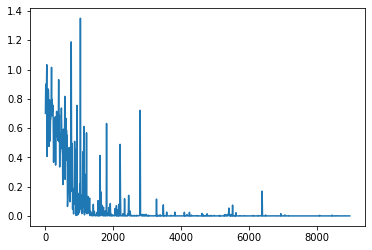

Epoch： 69  start.
Accuracy of the network on the 1000 : 55 %


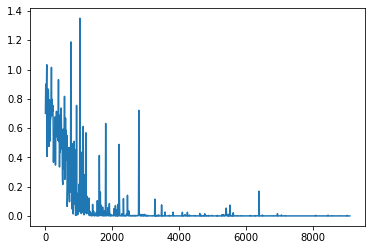

Epoch： 70  start.
Accuracy of the network on the 1000 : 54 %


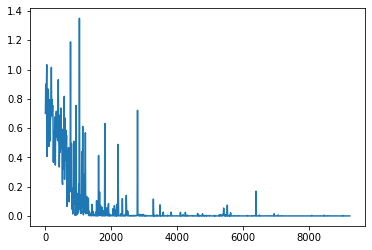

Epoch： 71  start.
Accuracy of the network on the 1000 : 55 %


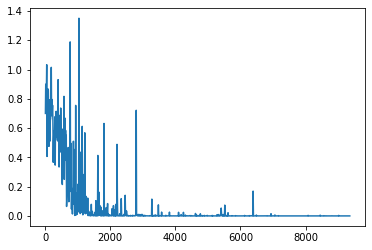

Epoch： 72  start.
Accuracy of the network on the 1000 : 54 %


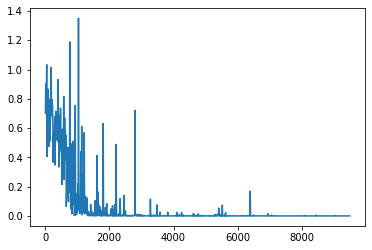

Epoch： 73  start.
Accuracy of the network on the 1000 : 54 %


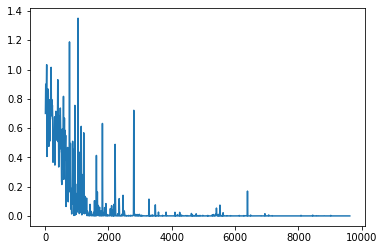

Epoch： 74  start.
Accuracy of the network on the 1000 : 55 %


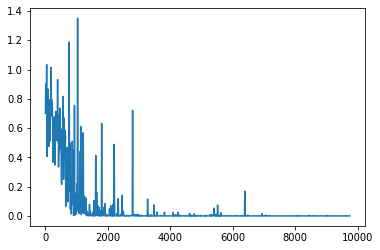

Epoch： 75  start.
Accuracy of the network on the 1000 : 55 %


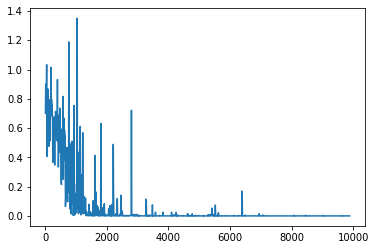

Epoch： 76  start.
Accuracy of the network on the 1000 : 55 %


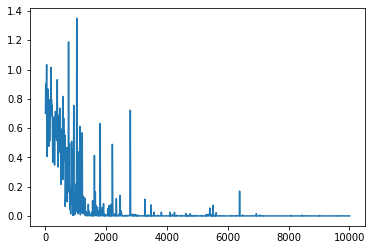

Epoch： 77  start.
Accuracy of the network on the 1000 : 53 %


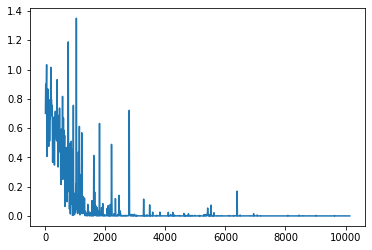

Epoch： 78  start.
Accuracy of the network on the 1000 : 54 %


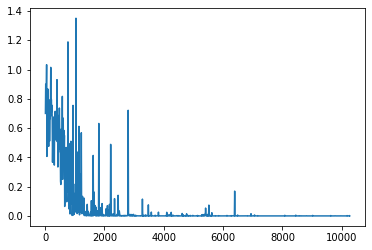

Epoch： 79  start.
Accuracy of the network on the 1000 : 55 %


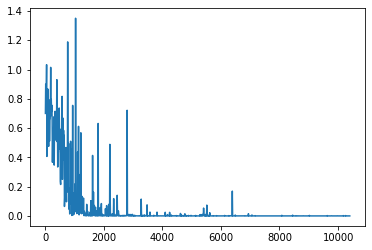

Epoch： 80  start.
Accuracy of the network on the 1000 : 53 %


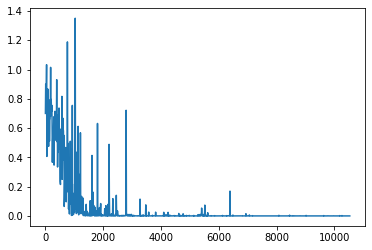

Epoch： 81  start.
Accuracy of the network on the 1000 : 54 %


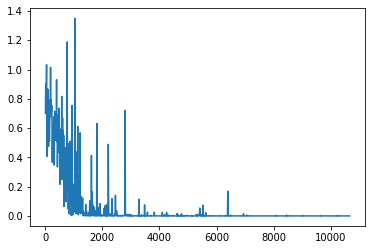

Epoch： 82  start.
Accuracy of the network on the 1000 : 57 %


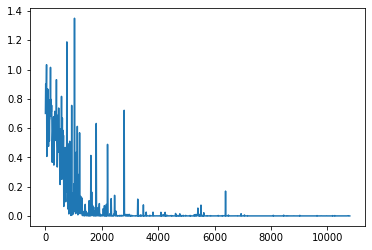

Epoch： 83  start.
Accuracy of the network on the 1000 : 50 %


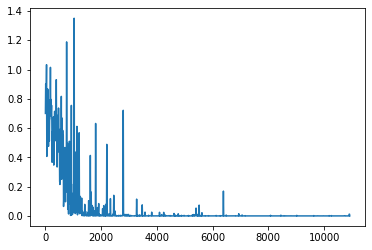

Epoch： 84  start.
Accuracy of the network on the 1000 : 52 %


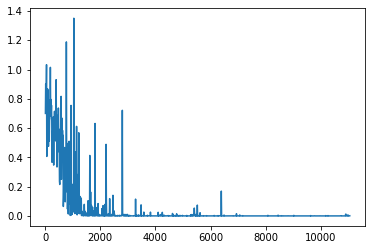

Epoch： 85  start.
Accuracy of the network on the 1000 : 51 %


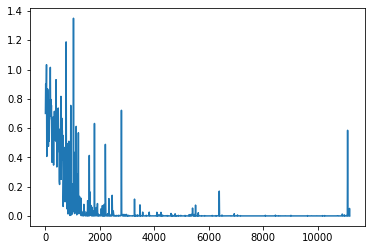

Epoch： 86  start.
Accuracy of the network on the 1000 : 54 %


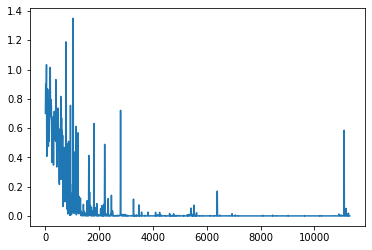

Epoch： 87  start.
Accuracy of the network on the 1000 : 54 %


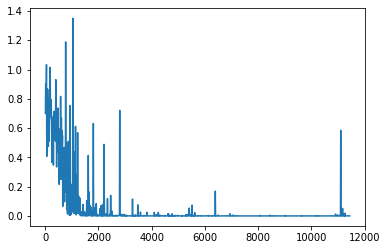

Epoch： 88  start.
Accuracy of the network on the 1000 : 56 %


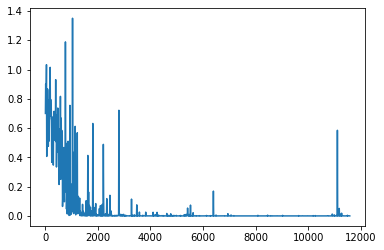

Epoch： 89  start.
Accuracy of the network on the 1000 : 54 %


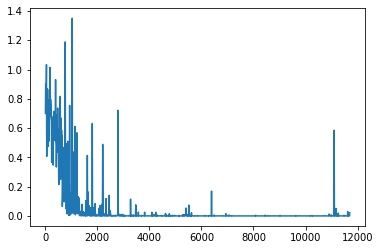

Epoch： 90  start.
Accuracy of the network on the 1000 : 56 %


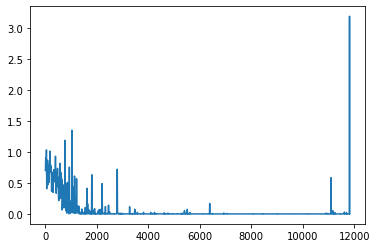

Epoch： 91  start.
Accuracy of the network on the 1000 : 56 %


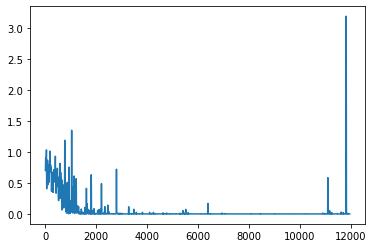

Epoch： 92  start.
Accuracy of the network on the 1000 : 53 %


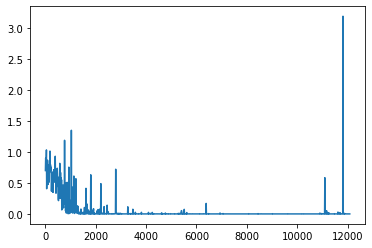

Epoch： 93  start.
Accuracy of the network on the 1000 : 54 %


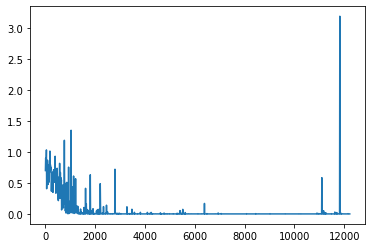

Epoch： 94  start.
Accuracy of the network on the 1000 : 54 %


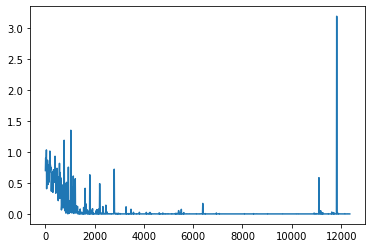

Epoch： 95  start.
Accuracy of the network on the 1000 : 54 %


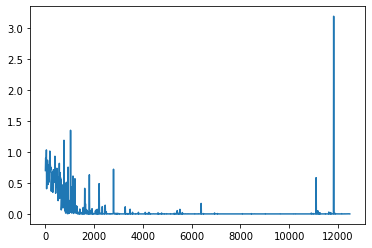

Epoch： 96  start.
Accuracy of the network on the 1000 : 52 %


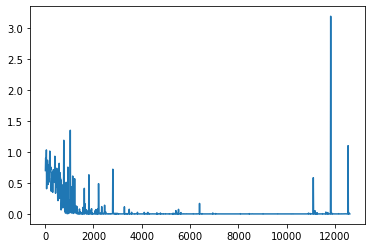

Epoch： 97  start.
Accuracy of the network on the 1000 : 55 %


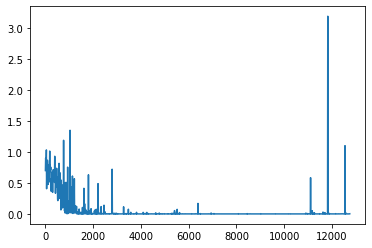

Epoch： 98  start.
Accuracy of the network on the 1000 : 55 %


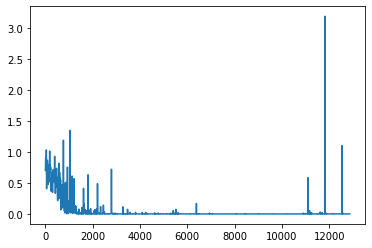

Epoch： 99  start.
Accuracy of the network on the 1000 : 55 %


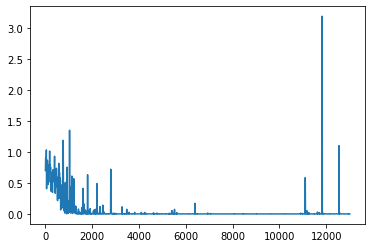

In [ ]:
net = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)